# Recommender Systems 2018/19

### Practice 8 - Hybrid recommenders


### The way to go to achieve the best recommendation quality

## A few info about hybrids


#### There are many different types of hibrids, in this practice we will see the following
* Linear combination of item-based models
* Linear combination of heterogeneous models
* User-wise discrimination


### Prerequisite: parameter tuning!

#### Let's have an example. In the course repo you will find a BayesianSearch object in the ParameterTuning folder. That is a simple wrapper of another library and its purpose is to provide a very simple way to tune some of the most common parameters. To run heavy tuning on more complex problems or with more sofisiticated constraints you may refer to other libraries.

In [3]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "data/Movielens_10M/movielens_10m.zip")
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



In [45]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


In [ ]:

from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)
URM_train, URM_validation = train_test_holdout(URM_train, train_perc = 0.9)

### Step 1: Import the evaluator objects

In [6]:
from ParameterTuning.AbstractClassSearch import EvaluatorWrapper
from Base.Evaluation.Evaluator import SequentialEvaluator

evaluator_validation = SequentialEvaluator(URM_validation, cutoff_list=[5])
evaluator_test = SequentialEvaluator(URM_test, cutoff_list=[5, 10])

evaluator_validation = EvaluatorWrapper(evaluator_validation)
evaluator_test = EvaluatorWrapper(evaluator_test)


### Step 2: Create BayesianSearch object

In [8]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from ParameterTuning.BayesianSearch import BayesianSearch


recommender_class = ItemKNNCFRecommender

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)



### Step 3: Define parameters range

In [9]:
from ParameterTuning.AbstractClassSearch import DictionaryKeys

hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["shrink"] = [0, 10, 50, 100, 200, 300, 500, 1000]
hyperparamethers_range_dictionary["similarity"] = ["cosine"]
hyperparamethers_range_dictionary["normalize"] = [True, False]


recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [URM_train],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}

output_root_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)



### Step 4: Run!

In [11]:
n_cases = 2
metric_to_optimize = "MAP"

best_parameters = parameterSearch.search(recommenderDictionary,
                                         n_cases = n_cases,
                                         output_root_path = output_root_path,
                                         metric=metric_to_optimize)

Initialization
----------------------------------------------------------------------------------
 Step |   Time |      Value |   normalize |    shrink |   similarity |      topK | 
BayesianSearch: Testing config: {'topK': 500, 'shrink': 100, 'similarity': 'cosine', 'normalize': False}
Similarity column 44696 ( 69 % ), 1489.86 column/sec, elapsed time 0.50 min
Similarity column 65134 ( 100 % ), 1701.74 column/sec, elapsed time 0.64 min
SequentialEvaluator: Processed 12001 ( 17.17% ) in 31.61 seconds. Users per second: 380
SequentialEvaluator: Processed 25001 ( 35.78% ) in 63.14 seconds. Users per second: 396
SequentialEvaluator: Processed 37422 ( 53.55% ) in 93.15 seconds. Users per second: 402
SequentialEvaluator: Processed 50001 ( 71.55% ) in 124.12 seconds. Users per second: 403
SequentialEvaluator: Processed 63001 ( 90.16% ) in 155.92 seconds. Users per second: 404
SequentialEvaluator: Processed 69878 ( 100.00% ) in 171.24 seconds. Users per second: 408
BayesianSearch: New best con

Similarity column 65134 ( 100 % ), 1777.11 column/sec, elapsed time 0.61 min
SequentialEvaluator: Processed 12001 ( 17.17% ) in 30.97 seconds. Users per second: 388
SequentialEvaluator: Processed 25001 ( 35.78% ) in 61.19 seconds. Users per second: 409
SequentialEvaluator: Processed 38001 ( 54.38% ) in 92.76 seconds. Users per second: 410
SequentialEvaluator: Processed 50355 ( 72.06% ) in 122.76 seconds. Users per second: 410
SequentialEvaluator: Processed 62001 ( 88.73% ) in 153.12 seconds. Users per second: 405
SequentialEvaluator: Processed 69878 ( 100.00% ) in 170.45 seconds. Users per second: 410
BayesianSearch: Config is suboptimal. Config: {'topK': 500, 'shrink': 100, 'similarity': 'cosine', 'normalize': False} - results: {'ROC_AUC': 0.5060593701403387, 'PRECISION': 0.42691261913625606, 'RECALL': 0.05515651067095852, 'RECALL_TEST_LEN': 0.42691261913625606, 'MAP': 0.3519586557205873, 'MRR': 0.6239574687312226, 'NDCG': 0.12588174301152777, 'F1': 0.09769142629967821, 'HIT_RATE': 2.

In [12]:
best_parameters

{'topK': 600, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}

# Linear combination of item-based models

#### Let's use an ItemKNNCF with the parameters we just learned and a graph based model

In [13]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_parameters)


from GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

Similarity column 63232 ( 97 % ), 1386.60 column/sec, elapsed time 0.76 min
Similarity column 65134 ( 100 % ), 1402.54 column/sec, elapsed time 0.77 min
Processed 44000 ( 67.55% ) in 1.00 minutes. Rows per second: 731


In [14]:
itemKNNCF.W_sparse

<65134x65134 sparse matrix of type '<class 'numpy.float32'>'
	with 6286723 stored elements in Compressed Sparse Row format>

In [15]:
P3alpha.W_sparse

<65134x65134 sparse matrix of type '<class 'numpy.float32'>'
	with 219887 stored elements in Compressed Sparse Row format>

### We may define another Recommender which takes the two matrices as input as well as the weights

In [22]:
from Base.Recommender import Recommender
from Base.Recommender_utils import check_matrix, similarityMatrixTopK
from Base.SimilarityMatrixRecommender import SimilarityMatrixRecommender


class ItemKNNSimilarityHybridRecommender(SimilarityMatrixRecommender, Recommender):
    """ ItemKNNSimilarityHybridRecommender
    Hybrid of two similarities S = S1*alpha + S2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNSimilarityHybridRecommender"


    def __init__(self, URM_train, Similarity_1, Similarity_2, sparse_weights=True):
        super(ItemKNNSimilarityHybridRecommender, self).__init__()

        if Similarity_1.shape != Similarity_2.shape:
            raise ValueError("ItemKNNSimilarityHybridRecommender: similarities have different size, S1 is {}, S2 is {}".format(
                Similarity_1.shape, Similarity_2.shape
            ))

        # CSR is faster during evaluation
        self.Similarity_1 = check_matrix(Similarity_1.copy(), 'csr')
        self.Similarity_2 = check_matrix(Similarity_2.copy(), 'csr')

        self.URM_train = check_matrix(URM_train.copy(), 'csr')

        self.sparse_weights = sparse_weights


    def fit(self, topK=100, alpha = 0.5):

        self.topK = topK
        self.alpha = alpha

        W = self.Similarity_1*self.alpha + self.Similarity_2*(1-self.alpha)

        if self.sparse_weights:
            self.W_sparse = similarityMatrixTopK(W, forceSparseOutput=True, k=self.topK)
        else:
            self.W = similarityMatrixTopK(W, forceSparseOutput=False, k=self.topK)



In [23]:
hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, itemKNNCF.W_sparse, P3alpha.W_sparse)
hybridrecommender.fit(alpha = 0.5)

In [24]:
evaluator_validation.evaluateRecommender(hybridrecommender)

SequentialEvaluator: Processed 4001 ( 5.73% ) in 30.89 seconds. Users per second: 130
SequentialEvaluator: Processed 25190 ( 36.05% ) in 61.03 seconds. Users per second: 413
SequentialEvaluator: Processed 47001 ( 67.26% ) in 91.57 seconds. Users per second: 513
SequentialEvaluator: Processed 68001 ( 97.31% ) in 122.28 seconds. Users per second: 556
SequentialEvaluator: Processed 69878 ( 100.00% ) in 124.64 seconds. Users per second: 561


({5: {'ROC_AUC': 0.5971121096768636,
   'PRECISION': 0.5502733335241292,
   'RECALL': 0.07793219220483752,
   'RECALL_TEST_LEN': 0.5502733335241292,
   'MAP': 0.47525382333011273,
   'MRR': 0.7227110106185191,
   'NDCG': 0.14804865207868584,
   'F1': 0.13652858956831587,
   'HIT_RATE': 2.7512664930307107,
   'ARHR': 1.318911293015624,
   'NOVELTY': 0.0007185835703278092,
   'DIVERSITY_MEAN_INTER_LIST': 0.9551846654513061,
   'DIVERSITY_HERFINDAHL': 0.9910341992264831,
   'COVERAGE_ITEM': 0.035634230970000305,
   'COVERAGE_USER': 0.9763860943438408,
   'DIVERSITY_GINI': 0.08577621403356887,
   'SHANNON_ENTROPY': 7.787088236293191}},
 'CUTOFF: 5 - ROC_AUC: 0.5971121, PRECISION: 0.5502733, RECALL: 0.0779322, RECALL_TEST_LEN: 0.5502733, MAP: 0.4752538, MRR: 0.7227110, NDCG: 0.1480487, F1: 0.1365286, HIT_RATE: 2.7512665, ARHR: 1.3189113, NOVELTY: 0.0007186, DIVERSITY_MEAN_INTER_LIST: 0.9551847, DIVERSITY_HERFINDAHL: 0.9910342, COVERAGE_ITEM: 0.0356342, COVERAGE_USER: 0.9763861, DIVERSITY_GI

### In this case the alpha coefficient is too a parameter to be tuned

# Linear combination of predictions

#### In case of models with incompatible structure (e.g., ItemKNN with UserKNN or MF) you may ensemble the prediction values

In [25]:
from MatrixFactorization.PureSVD import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

user_id = 42



PureSVDRecommender Computing SVD decomposition...
PureSVDRecommender Computing SVD decomposition... Done!


In [27]:
item_scores = itemKNNCF.compute_item_score(user_id)
item_scores

array([[ 0.        , 14.145684  , 13.599203  , ...,  0.        ,
         0.        ,  0.07821521]], dtype=float32)

In [28]:
item_scores = pureSVD.compute_item_score(user_id)
item_scores

array([-1.4399568e-07, -1.0878356e-01,  1.6590253e-01, ...,
        0.0000000e+00,  0.0000000e+00,  2.0369750e-03], dtype=float32)

In [31]:

class ItemKNNScoresHybridRecommender(Recommender):
    """ ItemKNNScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNScoresHybridRecommender"


    def __init__(self, URM_train, Recommender_1, Recommender_2):
        super(ItemKNNScoresHybridRecommender, self).__init__()

        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.Recommender_1 = Recommender_1
        self.Recommender_2 = Recommender_2
        
        self.compute_item_score = self.compute_score_hybrid
        
  
    def fit(self, alpha = 0.5):

        self.alpha = alpha      


    def compute_score_hybrid(self, user_id_array):
        
        item_weights_1 = self.Recommender_1.compute_item_score(user_id_array)
        item_weights_2 = self.Recommender_2.compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights


In [32]:
hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
hybridrecommender.fit(alpha = 0.5)

evaluator_validation.evaluateRecommender(hybridrecommender)

SequentialEvaluator: Processed 10001 ( 14.31% ) in 31.72 seconds. Users per second: 315
SequentialEvaluator: Processed 22001 ( 31.48% ) in 62.62 seconds. Users per second: 351
SequentialEvaluator: Processed 34001 ( 48.66% ) in 93.71 seconds. Users per second: 363
SequentialEvaluator: Processed 46001 ( 65.83% ) in 125.79 seconds. Users per second: 366
SequentialEvaluator: Processed 58001 ( 83.00% ) in 157.33 seconds. Users per second: 369
SequentialEvaluator: Processed 69878 ( 100.00% ) in 186.35 seconds. Users per second: 375


({5: {'ROC_AUC': 0.6181213448200189,
   'PRECISION': 0.5692337597908538,
   'RECALL': 0.08157308348771604,
   'RECALL_TEST_LEN': 0.5692337597908538,
   'MAP': 0.49841635898748854,
   'MRR': 0.743138040585039,
   'NDCG': 0.15475923359051175,
   'F1': 0.14269718731759018,
   'HIT_RATE': 2.8460745871375828,
   'ARHR': 1.3697708864022944,
   'NOVELTY': 0.0007099023770725256,
   'DIVERSITY_MEAN_INTER_LIST': 0.9446769986743312,
   'DIVERSITY_HERFINDAHL': 0.9889326959454083,
   'COVERAGE_ITEM': 0.023428624067307398,
   'COVERAGE_USER': 0.9763860943438408,
   'DIVERSITY_GINI': 0.08140527002876545,
   'SHANNON_ENTROPY': 7.269714354376191}},
 'CUTOFF: 5 - ROC_AUC: 0.6181213, PRECISION: 0.5692338, RECALL: 0.0815731, RECALL_TEST_LEN: 0.5692338, MAP: 0.4984164, MRR: 0.7431380, NDCG: 0.1547592, F1: 0.1426972, HIT_RATE: 2.8460746, ARHR: 1.3697709, NOVELTY: 0.0007099, DIVERSITY_MEAN_INTER_LIST: 0.9446770, DIVERSITY_HERFINDAHL: 0.9889327, COVERAGE_ITEM: 0.0234286, COVERAGE_USER: 0.9763861, DIVERSITY_GI

# User-wise hybrid

### Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model



In [33]:
URM_train = sps.csr_matrix(URM_train)

profile_length = np.ediff1d(URM_train.indptr)


### Let's select a few groups of 5% of the users with the least number of interactions

In [34]:
block_size = int(len(profile_length)*0.05)
block_size

3578

In [35]:
sorted_users = np.argsort(profile_length)

In [37]:
for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 4.13, min 0, max 9
Group 1, average p.len 10.26, min 9, max 11
Group 2, average p.len 12.24, min 11, max 13
Group 3, average p.len 13.98, min 13, max 15
Group 4, average p.len 15.93, min 15, max 17


### Now we plot the recommendation quality of TopPop and ItemKNNCF

In [38]:
from Base.NonPersonalizedRecommender import TopPop

topPop = TopPop(URM_train)
topPop.fit()


In [46]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


recommender_class = ItemKNNCBFRecommender

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


In [47]:

hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["shrink"] = [0, 10, 50, 100, 200, 300, 500, 1000]
hyperparamethers_range_dictionary["similarity"] = ["cosine"]
hyperparamethers_range_dictionary["normalize"] = [True, False]


recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [ICM_all, URM_train],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}

output_root_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

    
    
    
n_cases = 2
metric_to_optimize = "MAP"

best_parameters_ItemKNNCBF = parameterSearch.search(recommenderDictionary,
                                                 n_cases = n_cases,
                                                 output_root_path = output_root_path,
                                                 metric=metric_to_optimize)




Initialization
----------------------------------------------------------------------------------
 Step |   Time |      Value |   normalize |    shrink |   similarity |      topK | 
BayesianSearch: Testing config: {'topK': 100, 'shrink': 300, 'similarity': 'cosine', 'normalize': True}
Similarity column 56831 ( 87 % ), 1872.88 column/sec, elapsed time 0.51 min
Similarity column 65134 ( 100 % ), 1830.50 column/sec, elapsed time 0.59 min
SequentialEvaluator: Processed 17001 ( 24.33% ) in 31.02 seconds. Users per second: 548
SequentialEvaluator: Processed 36001 ( 51.52% ) in 61.39 seconds. Users per second: 586
SequentialEvaluator: Processed 54001 ( 77.28% ) in 91.95 seconds. Users per second: 587
SequentialEvaluator: Processed 69878 ( 100.00% ) in 118.53 seconds. Users per second: 590
BayesianSearch: New best config found. Config: {'topK': 100, 'shrink': 300, 'similarity': 'cosine', 'normalize': True} - results: {'ROC_AUC': 0.4021830905292083, 'PRECISION': 0.2746622685252045, 'RECALL': 0.

SequentialEvaluator: Processed 59001 ( 84.43% ) in 90.99 seconds. Users per second: 648
SequentialEvaluator: Processed 69878 ( 100.00% ) in 106.36 seconds. Users per second: 657
BayesianSearch: Config is suboptimal. Config: {'topK': 200, 'shrink': 10, 'similarity': 'cosine', 'normalize': False} - results: {'ROC_AUC': 0.41418019023631597, 'PRECISION': 0.2946719043667178, 'RECALL': 0.02771654495974247, 'RECALL_TEST_LEN': 0.2946719043667178, 'MAP': 0.24024121802765228, 'MRR': 0.4698808399400716, 'NDCG': 0.07366759106736098, 'F1': 0.0506673679085979, 'HIT_RATE': 1.473339248404362, 'ARHR': 0.7455765763186845, 'NOVELTY': 0.0007186205963870608, 'DIVERSITY_MEAN_INTER_LIST': 0.8676774258542752, 'DIVERSITY_HERFINDAHL': 0.9735330017642726, 'COVERAGE_ITEM': 0.0076611293640802035, 'COVERAGE_USER': 0.9763860943438408, 'DIVERSITY_GINI': 0.0937035404562237, 'SHANNON_ENTROPY': 5.884844682203921}

    4 | 02m11s |    0.24024 |      0.8966 |    1.3326 |       0.0000 |    6.1023 | 
BayesianSearch: Testing

In [48]:
best_parameters_ItemKNNCBF

NameError: name 'best_parameters_ItemKNNCBF' is not defined

In [49]:
itemKNNCBF = ItemKNNCBFRecommender(ICM_all, URM_train)
itemKNNCBF.fit(**best_parameters_ItemKNNCBF)

Similarity column 65134 ( 100 % ), 5513.89 column/sec, elapsed time 0.20 min


In [54]:



MAP_itemKNNCF_per_group = []
MAP_itemKNNCBF_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = SequentialEvaluator(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    
    results, _ = evaluator_test.evaluateRecommender(itemKNNCF)
    MAP_itemKNNCF_per_group.append(results[cutoff]["MAP"])
 
    results, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    MAP_itemKNNCBF_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])

    
    

Group 0, average p.len 4.13, min 0, max 9
Ignoring 67990 Users
SequentialEvaluator: Processed 1888 ( 100.00% ) in 3.10 seconds. Users per second: 609
SequentialEvaluator: Processed 1888 ( 100.00% ) in 2.94 seconds. Users per second: 642
SequentialEvaluator: Processed 1888 ( 100.00% ) in 3.13 seconds. Users per second: 603
Group 1, average p.len 10.26, min 9, max 11
Ignoring 67990 Users
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.37 seconds. Users per second: 666
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.50 seconds. Users per second: 651
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.52 seconds. Users per second: 648
Group 2, average p.len 12.24, min 11, max 13
Ignoring 67990 Users
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.71 seconds. Users per second: 627
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.55 seconds. Users per second: 644
SequentialEvaluator: Processed 3578 ( 100.00% ) in 5.48 seconds. Users per second: 653
Group 3, average p.len 

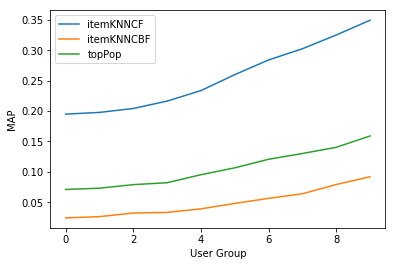

In [55]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_itemKNNCF_per_group, label="itemKNNCF")
pyplot.plot(MAP_itemKNNCBF_per_group, label="itemKNNCBF")
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()